# Para ejecutar en Google Colab en Drive

In [ ]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

In [ ]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/PruebasCOLAB3/OF-PathPred/tests")
!ls

# Inicio de Código

In [1]:
# Imports
import sys,os,logging
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('../bayesian-torch')
sys.path.append('../OF-PathPred')
sys.path.append('..')

import math,numpy as np
# Important imports
import matplotlib.pyplot as plt
from path_prediction.datasets_utils import setup_loo_experiment
from path_prediction.testing_utils import evaluation_minadefde,evaluation_qualitative,evaluation_attention,plot_comparisons_minadefde, get_testing_batch
from path_prediction.training_utils import Experiment_Parameters

import torch
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from bayesian_torch.layers import LinearReparameterization
from bayesian_torch.layers import LSTMReparameterization

# Local models
from models.lstm_encdec_variational import lstm_encdec_variational
from models.lstm_encdec import lstm_encdec
from models.moped import MOPED_layer
from utils.datasets_utils import traj_dataset


In [2]:
# In[5]:
logging.basicConfig(format='%(levelname)s: %(message)s',level=20)
# GPU
if torch.cuda.is_available():
    logging.info(torch.cuda.get_device_name(torch.cuda.current_device()))


INFO: NVIDIA GeForce GTX 1060


In [3]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_kp=False,obstacles=False)

dataset_dir   = "../OF-PathPred/datasets/"
dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']
#dataset_names = ['eth-hotel','eth-univ','ucy-zara01']
idTest        = 2

In [4]:
# Load the dataset and perform the split
training_data, validation_data, test_data, test_homography = setup_loo_experiment('ETH_UCY',dataset_dir,dataset_names,2,experiment_parameters,use_pickled_data=True,pickle_dir="../pickle")

INFO: Testing/validation dataset: ['ucy-zara01']
INFO: Training datasets: ['eth-hotel', 'eth-univ', 'ucy-zara02', 'ucy-univ']
INFO: Unpickling...
INFO: Training data: 15481
INFO: Test data: 2356
INFO: Validation data: 1720


In [6]:
num_epochs     = 55
initial_lr     = 0.02
batch_size     = 128
num_mc         = 1

In [7]:
# Creamos el dataset para torch
train_data = traj_dataset(training_data['obs_traj_rel'], training_data['pred_traj_rel'],training_data['obs_traj'], training_data['pred_traj'])
val_data   = traj_dataset(validation_data['obs_traj_rel'], validation_data['pred_traj_rel'],validation_data['obs_traj'], validation_data['pred_traj'])
test_data  = traj_dataset(test_data['obs_traj_rel'], test_data['pred_traj_rel'], test_data['obs_traj'], test_data['pred_traj'])

In [8]:
# Form batches
batched_train_data = torch.utils.data.DataLoader( train_data, batch_size = batch_size, shuffle=True)
batched_val_data =  torch.utils.data.DataLoader( val_data, batch_size = batch_size, shuffle=True)
batched_test_data =  torch.utils.data.DataLoader( test_data, batch_size = batch_size, shuffle=True)

In [9]:
prior_mu = 0.0
prior_sigma = 0.1
posterior_mu_init = 0.0
posterior_rho_init = -3.0 # 0.006715348489117967 # 0.01814992791780978 # 0.04858735157374196

len_trainset = 15481
len_valset = 1720

In [10]:
# Model Variational
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_encdec_variational(2,128,256,2,prior_mu,prior_sigma,posterior_mu_init,posterior_rho_init)
model.to(device)

lstm_encdec_variational(
  (embedding): LinearReparameterization()
  (lstm1): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (lstm2): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (decoder): LinearReparameterization()
  (loss_fun): MSELoss()
)

In [11]:
# Model Deterministic
det_model = lstm_encdec(2,128,256,2)

# Cargamos el Modelo
det_model.load_state_dict(torch.load("../training_checkpoints/model_deterministic5.pth"))
det_model.cuda()

lstm_encdec(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (lstm1): LSTM(128, 256)
  (lstm2): LSTM(128, 256)
  (decoder): Linear(in_features=256, out_features=2, bias=True)
  (loss_fun): MSELoss()
)

In [12]:
delta = 0.2

print("MOPED enabled")
for (idx_1, layer_1), (det_idx_1, det_layer_1) in zip( enumerate(model.children()), enumerate(det_model.children())):
    MOPED_layer(layer_1, det_layer_1, delta)
    for (idx_2, layer_2), (det_idx_2, det_layer_2) in zip( enumerate(layer_1.children()), enumerate(det_layer_1.children())):
        MOPED_layer(layer_2, det_layer_2, delta)

        for (idx_3, layer_3), (det_idx_3, det_layer_3) in zip( enumerate(layer_2.children()), enumerate(det_layer_2.children())):
            MOPED_layer(layer_3, det_layer_3, delta)
            for (idx_4, layer_4), (det_idx_4, det_layer_4) in zip( enumerate(layer_3.children()), enumerate(det_layer_3.children())):
                MOPED_layer(layer_4, det_layer_4, delta)
                for (idx_5, layer_5), (det_idx_5, det_layer_5) in zip( enumerate(layer_4.children()), enumerate(det_layer_4.children())):
                    MOPED_layer(layer_5, det_layer_5, delta)
                    for (idx_6, layer_6), (det_idx_6, det_layer_6) in zip( enumerate(layer_5.children()), enumerate(det_layer_5.children())):
                        MOPED_layer(layer_6, det_layer_6, delta)
model.state_dict()
del det_model

MOPED enabled
LinearReparameterization()
LinearReparameterization()


In [13]:
import torch.optim as optim

# Training the Model
optimizer = optim.SGD(model.parameters(), lr=initial_lr)

#optimizer = optim.SGD(model.parameters(), lr=0.015)
#optimizer = optim.SGD(model.parameters(), lr=0.03)
#optimizer = optim.SGD(model.parameters(), lr=0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.08) #nan
#optimizer = optim.SGD(model.parameters(), lr=0.07) #nan 
#optimizer = optim.SGD(model.parameters(), lr=0.06) #nan 

nll_losses_= []
kl_losses_ = []
errors_    = []
val_losses_= []
for epoch in range(num_epochs):
    # Training
    logging.info("----- ")
    logging.info("epoch: {}".format(epoch))
    nll_loss_sum = 0
    kl_loss_sum  = 0
    errors_sum   = 0
    M     = len(batched_train_data)
    for batch_idx, (data, target, _a , _b) in enumerate(batched_train_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        if torch.cuda.is_available():
            data  = data.to(device)
            target=target.to(device)

        # Step 2. Run our forward pass and compute the losses
        pred, nll_loss, kl_loss = model(data, target, training=True, num_mc=num_mc)
        loss   = nll_loss+ kl_loss/M

        nll_loss_sum+= nll_loss.detach().item()
        kl_loss_sum += kl_loss.detach().item()/M
        errors_sum  += loss.detach().item()

        # Step 3. Compute the gradients, and update the parameters by
        loss.backward()
        optimizer.step()
    logging.info("Average NLL loss: {:.3e}".format(nll_loss_sum/M))
    logging.info("Average KL loss: {:.3e}".format(kl_loss_sum/M))
    logging.info("Average training loss: {:.3e}".format(errors_sum/M))
    nll_losses_.append(nll_loss_sum/M)
    kl_losses_.append(kl_loss_sum/M)
    errors_.append(errors_sum/M)
    # Validation
    error = 0
    M     = len(batched_val_data)
    for batch_idx, (data_val, target_val, _ , _) in enumerate(batched_val_data):
        if torch.cuda.is_available():
            data_val  = data_val.to(device)
            target_val=target_val.to(device)
        pred_val, nll_loss, kl_loss = model(data_val, target_val)
        error += nll_loss.detach().item()
    val_losses_.append(error/M)    
    logging.info("Average validation loss: {:.3e}".format(error/M))


INFO: ----- 
INFO: epoch: 0
INFO: Average NLL loss: 5.557e-03
INFO: Average KL loss: 1.319e-01
INFO: Average training loss: 1.374e-01
INFO: Average validation loss: 1.200e+00
INFO: ----- 
INFO: epoch: 1
INFO: Average NLL loss: 4.877e-03
INFO: Average KL loss: 1.317e-01
INFO: Average training loss: 1.366e-01
INFO: Average validation loss: 1.193e+00
INFO: ----- 
INFO: epoch: 2
INFO: Average NLL loss: 4.779e-03
INFO: Average KL loss: 1.316e-01
INFO: Average training loss: 1.364e-01
INFO: Average validation loss: 1.206e+00
INFO: ----- 
INFO: epoch: 3
INFO: Average NLL loss: 4.507e-03
INFO: Average KL loss: 1.314e-01
INFO: Average training loss: 1.359e-01
INFO: Average validation loss: 1.180e+00
INFO: ----- 
INFO: epoch: 4
INFO: Average NLL loss: 4.580e-03
INFO: Average KL loss: 1.313e-01
INFO: Average training loss: 1.359e-01
INFO: Average validation loss: 1.177e+00
INFO: ----- 
INFO: epoch: 5
INFO: Average NLL loss: 4.342e-03
INFO: Average KL loss: 1.311e-01
INFO: Average training loss: 1

INFO: Average validation loss: 1.100e+00
INFO: ----- 
INFO: epoch: 47
INFO: Average NLL loss: 2.891e-03
INFO: Average KL loss: 1.250e-01
INFO: Average training loss: 1.279e-01
INFO: Average validation loss: 1.101e+00
INFO: ----- 
INFO: epoch: 48
INFO: Average NLL loss: 2.891e-03
INFO: Average KL loss: 1.249e-01
INFO: Average training loss: 1.278e-01
INFO: Average validation loss: 1.098e+00
INFO: ----- 
INFO: epoch: 49
INFO: Average NLL loss: 2.886e-03
INFO: Average KL loss: 1.247e-01
INFO: Average training loss: 1.276e-01
INFO: Average validation loss: 1.097e+00
INFO: ----- 
INFO: epoch: 50
INFO: Average NLL loss: 2.852e-03
INFO: Average KL loss: 1.246e-01
INFO: Average training loss: 1.275e-01
INFO: Average validation loss: 1.097e+00
INFO: ----- 
INFO: epoch: 51
INFO: Average NLL loss: 2.857e-03
INFO: Average KL loss: 1.245e-01
INFO: Average training loss: 1.273e-01
INFO: Average validation loss: 1.093e+00
INFO: ----- 
INFO: epoch: 52
INFO: Average NLL loss: 2.888e-03
INFO: Average KL

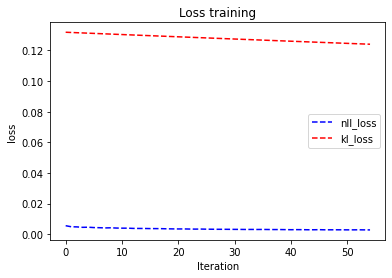

In [14]:
plt.plot(nll_losses_,"--b", label="nll_loss")
plt.plot(kl_losses_,"--r", label="kl_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

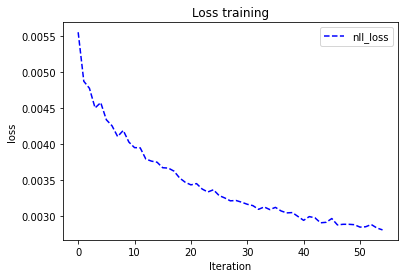

In [15]:
plt.plot(nll_losses_,"--b", label="nll_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

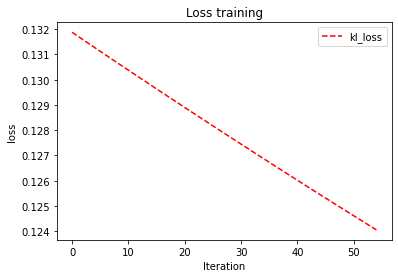

In [16]:
plt.plot(kl_losses_,"--r", label="kl_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

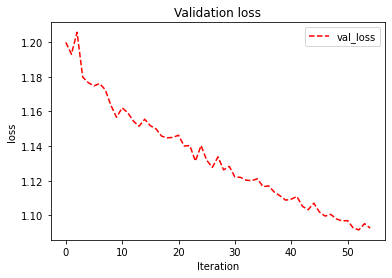

In [17]:
plt.plot(val_losses_,"--r", label="val_loss")
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [18]:
# Guardamos el Modelo
torch.save(model.state_dict(), "../training_checkpoints/model_MOPED.pth")

In [19]:
def plot_traj(pred_traj, obs_traj_gt, pred_traj_gt, test_homography, background):
    print("-----")
    homography = np.linalg.inv(test_homography)

    # Convert it to absolute (starting from the last observed position)
    displacement = np.cumsum(pred_traj, axis=0)
    this_pred_out_abs = displacement + np.array([obs_traj_gt[-1].numpy()])

    obs   = image_to_world_xy(obs_traj_gt, homography, flip=False)
    gt    = image_to_world_xy(pred_traj_gt, homography, flip=False)
    gt = np.concatenate([obs[-1,:].reshape((1,2)), gt],axis=0)
    tpred   = image_to_world_xy(this_pred_out_abs, homography, flip=False)
    tpred = np.concatenate([obs[-1,:].reshape((1,2)), tpred],axis=0)

    plt.figure(figsize=(12,12))
    plt.imshow(background)
    plt.plot(obs[:,0],obs[:,1],"-b", linewidth=2, label="Observations")
    plt.plot(gt[:,0], gt[:,1],"-r", linewidth=2, label="Ground truth")
    plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2, label="Prediction")
    plt.legend()
    plt.title('Trajectory samples')
    plt.show()


-----
0


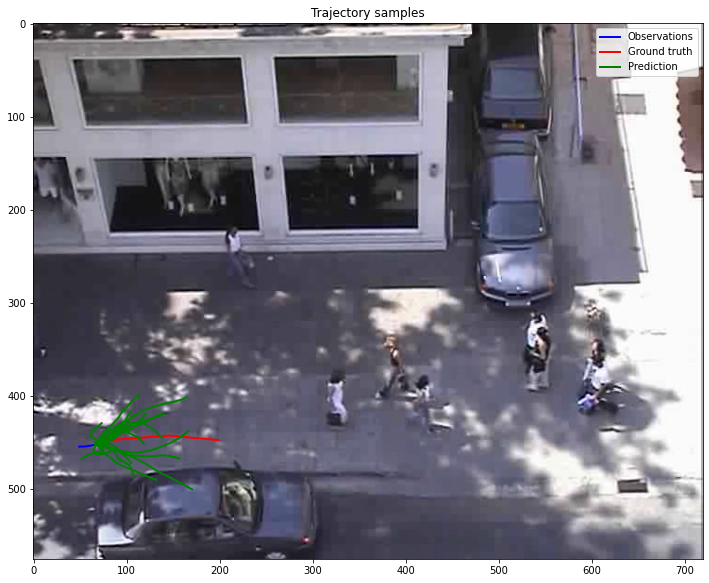

-----
1


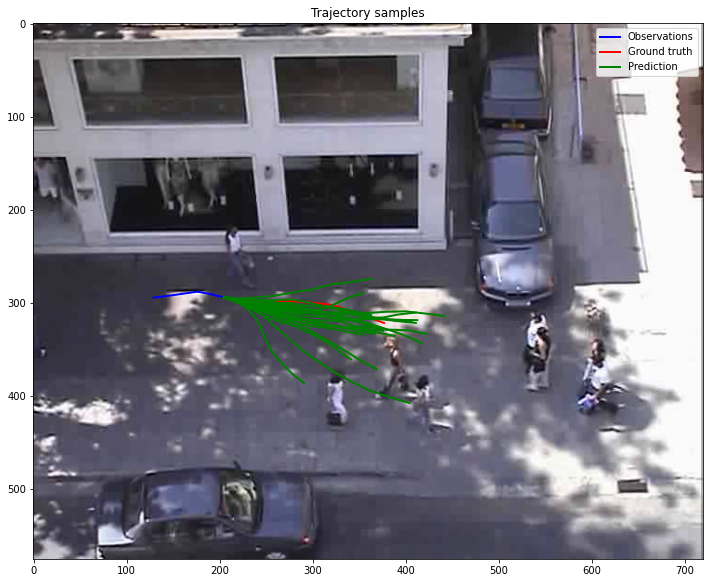

-----
2


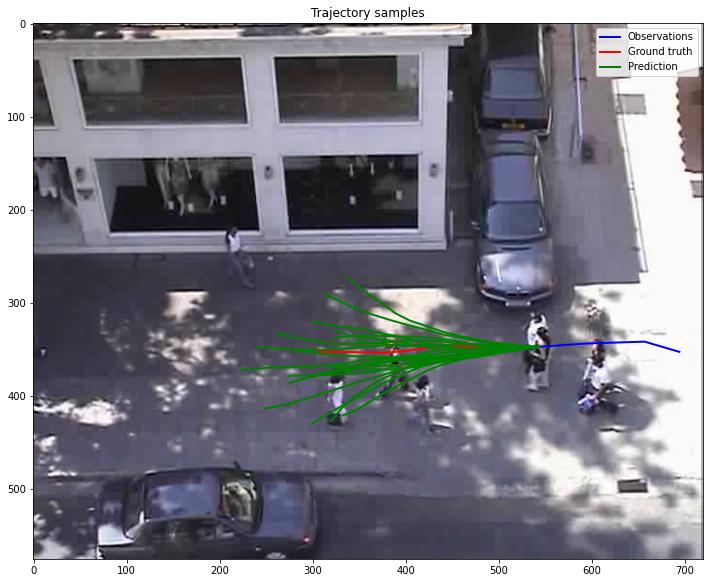

-----
3


In [ ]:
from path_prediction.obstacles import image_to_world_xy

num_samples = 30
num_monte_carlo = 20
i = 1 # sample of batch
bck = plt.imread(os.path.join(dataset_dir,dataset_names[idTest],'reference.png'))

# Testing
cont = 0
for batch_idx, (datarel_test, targetrel_test, data_test, target_test) in enumerate(batched_test_data):
    print("-----")
    print(cont)
    if torch.cuda.is_available():
        datarel_test  = datarel_test.to(device)
        targetrel_test= targetrel_test.to(device)
        data_test     = data_test.to(device)
        target_test   = target_test.to(device)        
    homography = np.linalg.inv(test_homography)
    
    obs_traj_gt  = data_test[i,:,:]
    pred_traj_gt = target_test[i,:,:]
    obs   = image_to_world_xy(obs_traj_gt.cpu(), homography, flip=False)
    gt    = image_to_world_xy(pred_traj_gt.cpu(), homography, flip=False)
    gt = np.concatenate([obs[-1,:].reshape((1,2)), gt], axis=0)

    plt.figure(figsize=(12,12))
    plt.imshow(bck)
    plt.plot(obs[:,0],obs[:,1],"-b", linewidth=2, label="Observations")
    plt.plot(gt[:,0], gt[:,1],"-r", linewidth=2, label="Ground truth")

    # prediction
    for mc_run in range(num_monte_carlo):
        pred, kl = model.predict(datarel_test, dim_pred=12)
        # ploting 
        #plot_traj(pred[i,:,:], data_test[i,:,:], target_test[i,:,:], test_homography, bck)

        pred_traj = pred[i,:,:]

        # Convert it to absolute (starting from the last observed position)
        displacement      = np.cumsum(pred_traj, axis=0)
        this_pred_out_abs = displacement + np.array([obs_traj_gt[-1].cpu().numpy()])

        tpred = image_to_world_xy(this_pred_out_abs, homography, flip=False)
        tpred = np.concatenate([obs[-1,:].reshape((1,2)), tpred], axis=0)

        if mc_run == 0:
            plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2, label="Prediction")
        else:
            plt.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2)

    plt.legend()
    plt.title('Trajectory samples')
    plt.savefig("traj_variational_1_4"+str(cont)+".pdf")
    plt.show()

    cont += 1
        
    if cont == num_samples:
        break